In [69]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2

np.random.seed(42)
tf.random.set_seed(42)
from deslant_img import deslant_img

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

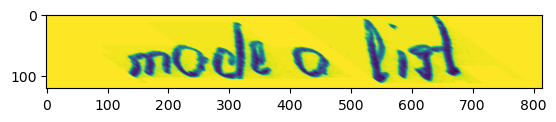

In [4]:
img = cv2.imread("C:\\Users\\Ahmad\\test5.png", cv2.IMREAD_GRAYSCALE)
res = deslant_img(img)
plt.imshow(res.img)
plt.show()

In [70]:
# Remove the hashes from the text file A.S
base_path = "C:\\Users\\Ahmad\\words"
words_list = []

words = open(f"{base_path}\\words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if (line.split(" ")[1] != "err") and (len(line.split(" ")) <= 9):  # We don't need to deal with errored entries.
        words_list.append(line)                                      # I added the length checking part to ignore words with spaces in it A.S

len(words_list)

np.random.shuffle(words_list)

In [71]:
# Split the data for 90 percent training the model, 5 percent testing the model, 5 percent validation A.S
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86787
Total validation samples: 4821
Total test samples: 4822


In [72]:
# Get the image paths from the data A.S
base_image_path = base_path


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    unwanted_labels = ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?']
    for (i, file_line) in enumerate(samples):
        unwanted_word = False
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        image_label = line_split[8]
#         for letter in image_label:
#             if(letter in unwanted_labels):
#                 unwanted_word = True
#         if(not unwanted_word):
        img_path = os.path.join(
        base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
                paths.append(img_path)
                corrected_samples.append(file_line.split("\n")[0])
    return paths, corrected_samples
    

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [73]:
# Take the last part of the data (expected word) and store it into a list A.S
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:100]


Maximum length:  21
Vocab size:  78


['fact',
 'on',
 'and',
 'If',
 'being',
 'too',
 'eye',
 'to',
 'victory',
 'that',
 'least',
 'the',
 ',',
 'but',
 'the',
 'event',
 'too',
 'towns',
 '"',
 'for',
 'Valet',
 '"',
 'A',
 'this',
 'steel',
 'coloured',
 'list',
 '.',
 'ministers',
 'mean',
 'again',
 'came',
 'can',
 'sheet',
 "'",
 'to',
 'the',
 '.',
 '"',
 'of',
 'her',
 'Roy',
 'TOLD',
 '-',
 'of',
 'lot',
 'raining',
 'the',
 'of',
 '1ye',
 'me',
 'are',
 'normal',
 'being',
 'on',
 'and',
 'obligations',
 'cleaning',
 '-',
 'no',
 'you',
 'slightest',
 'Sahara',
 'the',
 'a',
 'resource',
 ',',
 'piece',
 'care',
 'ill',
 ',',
 'used',
 'Duke',
 'what',
 'hexagonal',
 ',',
 'in',
 'he',
 'courses',
 ',',
 'thought',
 'of',
 'Labour',
 'philosophers',
 'of',
 '"',
 'Informal',
 'it',
 'be',
 'was',
 '-',
 'investment',
 'anti-climax',
 'swirled',
 'it',
 'the',
 ',',
 'the',
 'plastic',
 'this']

In [74]:
# Identify the labels from the test and validation sets A.S
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [75]:
# Convert characters and strings to numbers in order to go in mathematical equations A.S
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [76]:
# Resizing the image A.S
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image) # Flipping the image improves the accuracy A.S
    #deslant_img(img) # I added this to make the image upright not italic for improved accuracy A.S
    return image

In [77]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [78]:
# Calling the above functions A.S
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

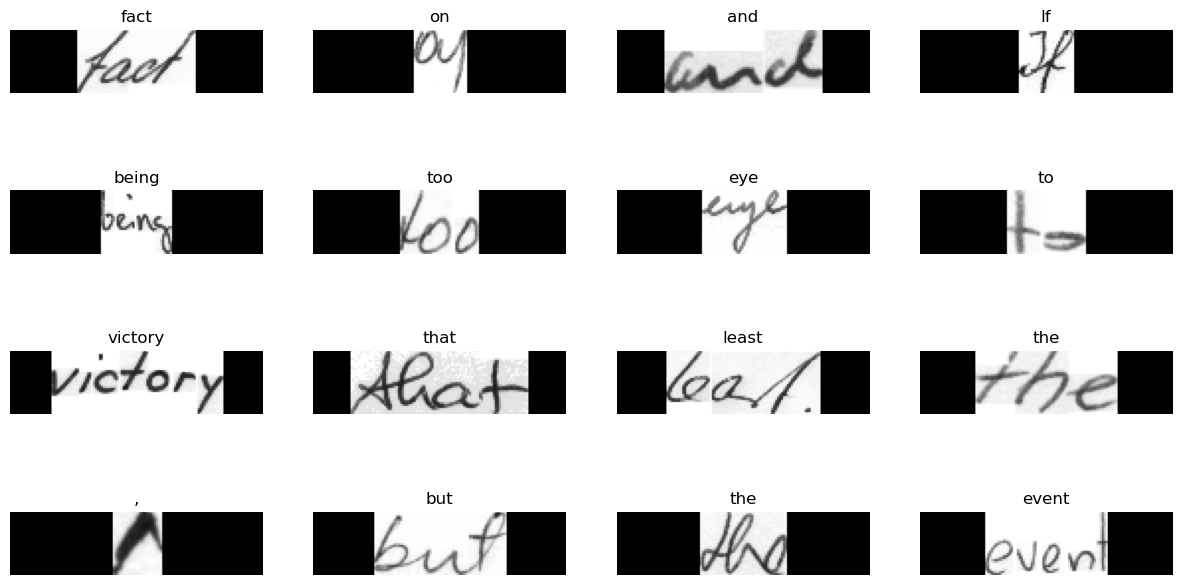

In [79]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [80]:
class CTCLayer(keras.layers.Layer):
#     def __init__(sel, **kwargs):
#         self.init = initializers.get('normal')
#         self.supports_masking = True
#         self.loss_fn = keras.backend.ctc_batch_cost
#         super(AttLayer, self).__init__(**kwargs)
    def __init__(self, name=None, **kwargs):
        super(CTCLayer, self).__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        super(CTCLayer, self).__init__(**kwargs)
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    
    
    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    
     # Third conv block.
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    
         # Fifth conv block.
    x = keras.layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)
    
    #Fourth conv block.
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",

        name="Conv4",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool4")(x)
    
    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv5",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool5")(x)
    

    
    


    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.

    #new_shape = ((image_width // 8), (image_height // 8) * 32)
    x = keras.layers.Reshape((32, -1))(x)
    #x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(256, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(256, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
#     model = keras.models.Model(
#         inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
#     )
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 64)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 128)  73856       ['pool1[0][0

In [81]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [82]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [83]:
from keras.callbacks import ModelCheckpoint

In [84]:
epochs = 50 # To get good results this should be at least 50.

model = build_model()
keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(model)

# Train the model.
# checkpoint = ModelCheckpoint('modelCheckpoints.h5', save_weights_only=True, save_best_only=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint('modelCheckpoints.h5',
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[cp_callback],
)
model.save('model.h5')

Epoch 1/50
1357/1357 [==============================] - ETA: 0s - loss: 12.2730
Epoch 1: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 154s 110ms/step - loss: 12.2730 - val_loss: 9.7198
Epoch 2/50
1356/1357 [============================>.] - ETA: 0s - loss: 8.6151
Epoch 2: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 80s 59ms/step - loss: 8.6152 - val_loss: 7.8928
Epoch 3/50
1356/1357 [============================>.] - ETA: 0s - loss: 6.9710
Epoch 3: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 80s 59ms/step - loss: 6.9711 - val_loss: 6.3798
Epoch 4/50
1356/1357 [============================>.] - ETA: 0s - loss: 5.8574
Epoch 4: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 80s 59ms/step - loss: 5.8575 - val_loss: 5.6172
Epoch 5/50
1356/1357 [============================>.] - ETA: 0s - loss: 5.0706
Epoch 5: saving model to modelCheckpoints.h5
1357

1357/1357 [==============================] - 81s 60ms/step - loss: 1.0840 - val_loss: 3.9241
Epoch 39/50
1356/1357 [============================>.] - ETA: 0s - loss: 1.0489
Epoch 39: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 81s 59ms/step - loss: 1.0489 - val_loss: 4.0379
Epoch 40/50
1356/1357 [============================>.] - ETA: 0s - loss: 1.0225
Epoch 40: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 81s 59ms/step - loss: 1.0225 - val_loss: 3.9978
Epoch 41/50
1356/1357 [============================>.] - ETA: 0s - loss: 1.0067
Epoch 41: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 81s 60ms/step - loss: 1.0067 - val_loss: 4.0062
Epoch 42/50
1356/1357 [============================>.] - ETA: 0s - loss: 0.9852
Epoch 42: saving model to modelCheckpoints.h5
1357/1357 [==============================] - 82s 60ms/step - loss: 0.9853 - val_loss: 3.9658
Epoch 43/50
1356/1357 [========

In [85]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

2/2 [==============================] - 1s 15ms/step


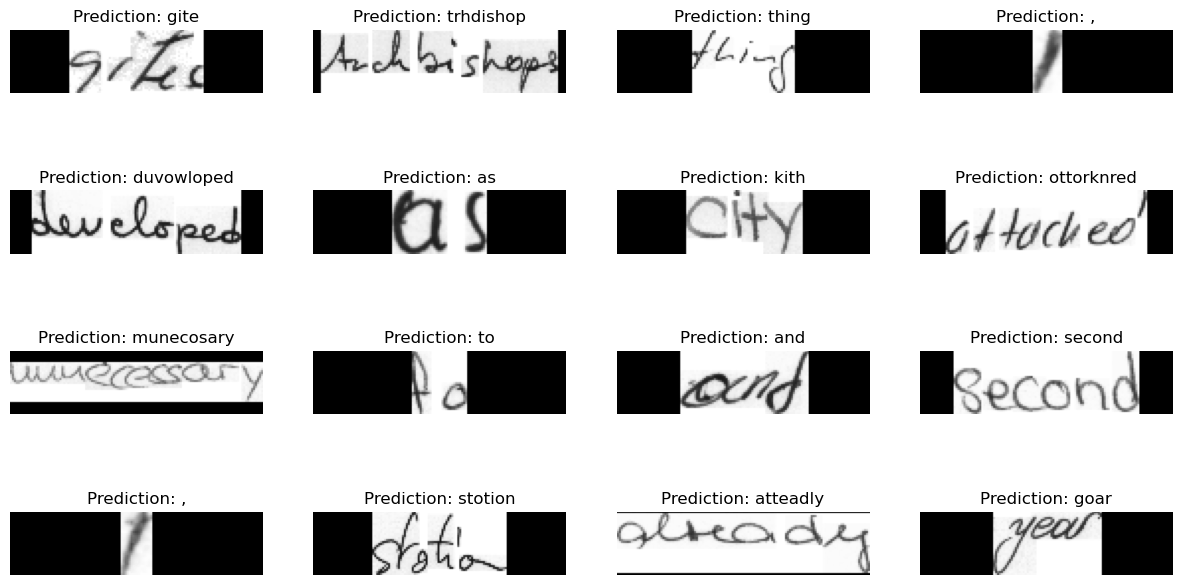

In [86]:
# Testing the data A.S
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# prediction_model.compile()
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

Run the above code once and run the below code every time you want to test something :) A.S

In [22]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [23]:
characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len = 21
# Convert characters and strings to numbers in order to go in mathematical equations A.S
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [24]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [25]:
class CTCLayer(keras.layers.Layer):
#     def __init__(sel, **kwargs):
#         self.init = initializers.get('normal')
#         self.supports_masking = True
#         self.loss_fn = keras.backend.ctc_batch_cost
#         super(AttLayer, self).__init__(**kwargs)
    def __init__(self, name=None, **kwargs):
        super(CTCLayer, self).__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        super(CTCLayer, self).__init__(**kwargs)
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [26]:
new_model = tf.keras.models.load_model('model.h5', custom_objects={'CTCLayer': CTCLayer})

In [27]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

NameError: name 'test_images' is not defined

In [28]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.new_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.new_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [29]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense

In [30]:
model = build_model()
prediction_model = keras.models.Model(
    new_model.get_layer(name="image").input, new_model.get_layer(name="dense2").output
)
# edit_distance_callback = EditDistanceCallback(prediction_model)
# # model.load_weights('model.h5')

In [31]:
# Optimizer.
opt = keras.optimizers.Adam()
# Compile the model and return.
new_model.compile(optimizer=opt)

In [32]:
# Resizing the image A.S
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image) # Flipping the image improves the accuracy A.S
    return image

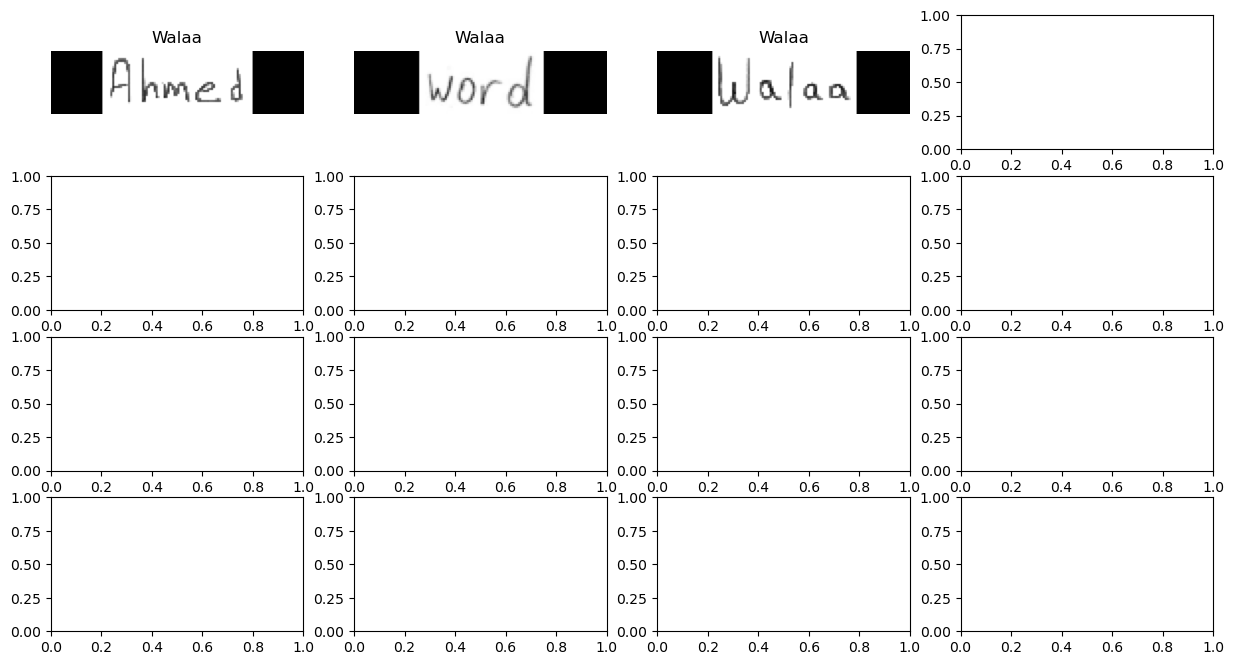

In [109]:
output_ds = prepare_dataset(['C:\\Users\\Ahmad\\words\\Ahmed.png','C:\\Users\\Ahmad\\words\\word.png','C:\\Users\\Ahmad\\words\\walaa3.png'], ['Walaa','Walaa','Walaa'])
for data in output_ds.take(1):
    images, labels = data["image"], data["label"]
    
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(3):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [110]:
import numpy as np
import cv2

# read
img = cv2.imread('C:\\Users\\Ahmad\\words\\walaa2.png', cv2.IMREAD_GRAYSCALE)

# increase contrast
pxmin = np.min(img)
pxmax = np.max(img)
imgContrast = (img - pxmin) / (pxmax - pxmin) * 255

# increase line width
kernel = np.ones((3, 3), np.uint8)
imgMorph = cv2.erode(imgContrast, kernel, iterations = 1)

# write
cv2.imwrite('out.png', imgMorph)

True

1/1 [==============================] - 0s 24ms/step


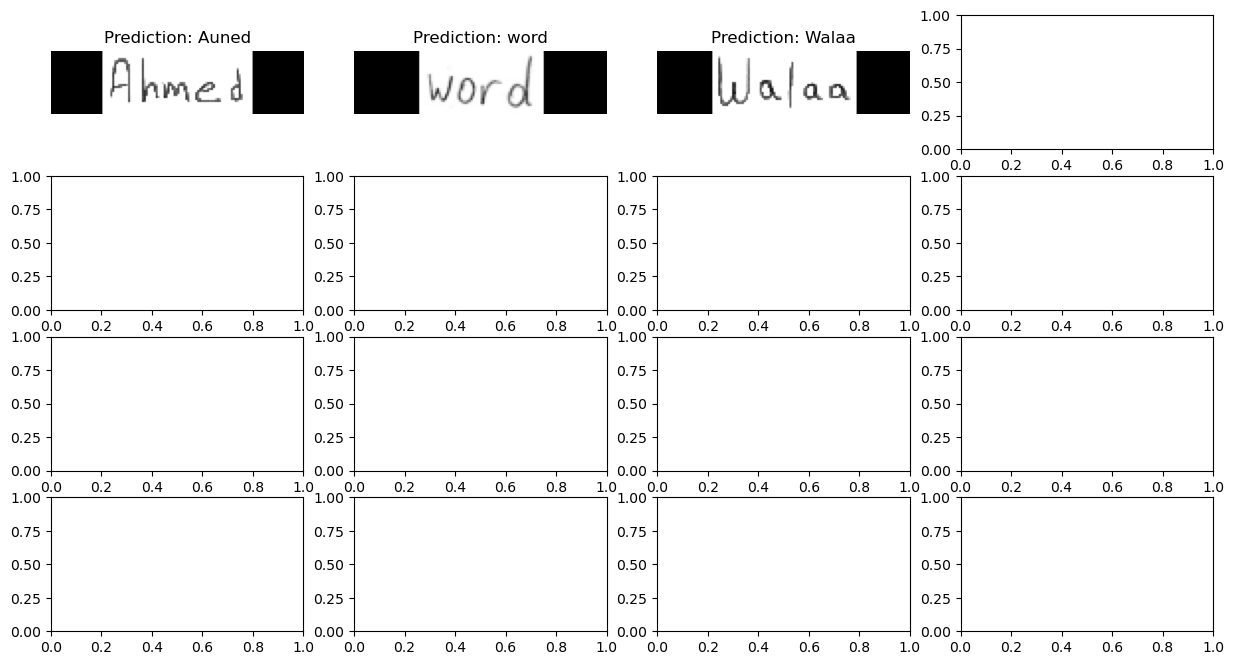

In [111]:
#pred_texts = decode_batch_predictions(output_ds)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in output_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(3):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()